In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


##Have to transpose because the data has what we need in rows, not columns
games_df = pd.read_json('cleaned_data.json').transpose()
zac_df = pd.read_json('output_data_zac.json').transpose()
rei_df = pd.read_json('output_data_rei.json').transpose()
marsh_df = pd.read_json('output_data_marsh.json').transpose()

##Preps the data with only the features we want
features = ['tags', 'positive', 'negative']

prepared_games_df = games_df[features]
prepared_zac_df = zac_df[features]
prepared_rei_df = rei_df[features]
prepared_marsh_df = marsh_df[features]

In [2]:
def preprocess_data(df):
    ##This gets rid of any NaN instances and replaces them with 0
    df['tags'].fillna(0, inplace=True)

    ##Processes the tags in order for them to actually be used for classification
    tags_binary = pd.get_dummies(df['tags'].apply(pd.Series), prefix='tag')

    ##Adds these tags to the frame
    df = pd.concat([df, tags_binary], axis=1)

    ##Gets rid of the original tags column
    df.drop('tags', axis=1, inplace=True)

    ##Sets up the positive and negative counts which are soon to be scaled
    df['positive_normalized'] = (df['positive'] - df['positive'].min()) / (df['positive'].max() - df['positive'].min())
    df['negative_normalized'] = (df['negative'] - df['negative'].min()) / (df['negative'].max() - df['negative'].min())

    ##Just like categories and genres, dropping the original ones
    df.drop(['positive', 'negative'], axis=1, inplace=True)

    ##Makes doubly sure that there are no NaN instances in the final data
    df.fillna(0, inplace=True)

    return df

preprocessed_games_df = preprocess_data(prepared_games_df)
preprocessed_zac_df = preprocess_data(prepared_zac_df)
preprocessed_rei_df = preprocess_data(prepared_rei_df)
preprocessed_marsh_df = preprocess_data(prepared_marsh_df)


Streaming output truncated to the last 5000 lines.
  tags_binary = pd.get_dummies(df['tags'].apply(pd.Series), prefix='tag')
<ipython-input-2-869d819a8afd>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tags_binary = pd.get_dummies(df['tags'].apply(pd.Series), prefix='tag')
<ipython-input-2-869d819a8afd>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tags_binary = pd.get_dummies(df['tags'].apply(pd.Series), prefix='tag')
<ipython-input-2-869d819a8afd>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tags_binary = pd.get_dummies(df['tags'].apply(pd.Series), prefix='tag')
<ipython-input-2-869d819a8afd>:6: FutureWarning: The default dtype f

In [3]:
preprocessed_games_df

,Indie,Casual,Sports,Bowling,Action,Pixel Graphics,2D,Retro,Arcade,Score Attack,...,Coding,Football (Soccer),Hobby Sim,Tile-Matching,Mahjong,Birds,Football (American),Fox,positive_normalized,negative_normalized
20200,22.0,21.0,21.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000012
655370,109.0,62.0,0.0,0.0,103.0,100.0,97.0,93.0,86.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.000006
1732930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1355720,21.0,21.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0
1139950,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619420,553.0,579.0,0.0,0.0,616.0,0.0,0.0,0.0,519.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.000003
2224030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2503930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2524860,0.0,294.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001


In [4]:
preprocessed_zac_df

,FPS,Action,Sci-fi,Classic,Singleplayer,Story Rich,Shooter,First-Person,Adventure,Dystopian,...,Tower Defense,TrackIR,Immersive Sim,Card Battler,Deckbuilding,FMV,Battle Royale,Tutorial,positive_normalized,negative_normalized
220,3917.0,2790.0,2434.0,2221.0,2160.0,1861.0,1678.0,1566.0,1340.0,1179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024698,0.004115
340,1022.0,359.0,245.0,108.0,307.0,38.0,221.0,250.0,104.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001614,0.001407
1510,0.0,0.0,48.0,55.0,117.0,27.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000339,0.00021
4000,6073.0,5466.0,0.0,0.0,5994.0,0.0,5287.0,7854.0,4601.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142655,0.032371
500,1110.0,959.0,0.0,0.0,395.0,0.0,764.0,568.0,284.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006981,0.001797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1364780,0.0,84.0,0.0,0.0,11.0,0.0,0.0,0.0,71.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000759,0.000521
1086940,0.0,0.0,0.0,0.0,0.0,875.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,0.007818,0.007382
440,14723.0,11510.0,0.0,0.0,0.0,0.0,12009.0,7341.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142893,0.063264


In [5]:
preprocessed_rei_df

,Tabletop,Board Game,Simulation,Multiplayer,Sandbox,Card Game,Trading Card Game,VR,Physics,3D,...,Immersive Sim,Realistic,Stylized,Resource Management,Addictive,Traditional Roguelike,Puzzle-Platformer,Narration,positive_normalized,negative_normalized
286160,938.0,800.0,572.0,535.0,438.0,388.0,355.0,337.0,332.0,322.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08753,0.067418
367520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40297,0.132832
322330,0.0,0.0,9682.0,9784.0,40635.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.569027,0.255893
290340,458.0,542.0,0.0,0.0,0.0,511.0,0.0,0.0,0.0,473.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020462,0.050053
391540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303227,0.117067
438100,0.0,0.0,574.0,1032.0,129.0,0.0,0.0,1531.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214931,0.623976
440310,0.0,0.0,0.0,276.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002652,0.001041
597220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012462,0.003411
698780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298891,0.115929
736260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027329,0.005743


In [6]:
preprocessed_marsh_df

,FPS,Singleplayer,Sci-fi,Multiplayer,1990's,Action,Classic,Shooter,First-Person,Aliens,...,Battle Royale,Hero Shooter,Destruction,Souls-like,Warhammer 40K,Turn-Based Tactics,Wargame,Artificial Intelligence,positive_normalized,negative_normalized
70,2259.0,1785.0,1785.0,1783.0,1778.0,1777.0,1770.0,1769.0,1762.0,1757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012724,0.003416
220,3917.0,2160.0,2434.0,653.0,0.0,2790.0,2221.0,1678.0,1566.0,923.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024698,0.004809
340,1022.0,307.0,245.0,40.0,0.0,359.0,108.0,221.0,250.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001614,0.001645
320,482.0,18.0,182.0,408.0,0.0,866.0,0.0,260.0,241.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001689,0.001371
360,160.0,7.0,86.0,124.0,0.0,242.0,71.0,96.0,76.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000424,0.001063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1740720,0.0,210.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000568,0.000686
1929610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489630,0.0,81.0,103.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,162.0,96.0,90.0,40.0,0.000852,0.00162


In [44]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score ##This import for f1 score ended up being unneeded for now, but it may be a better way of scoring accuracy than accuracy itself
combined_dataset = pd.concat([preprocessed_games_df, preprocessed_marsh_df, preprocessed_rei_df, preprocessed_zac_df], ignore_index=True)
combined_dataset['source'] = ['games'] * len(preprocessed_games_df) + ['marsh'] * len(preprocessed_marsh_df) + ['rei'] * len(preprocessed_rei_df) + ['zac'] * len(preprocessed_zac_df)

X = combined_dataset.drop('source', axis=1)
y = (combined_dataset['source'] == 'zac').astype(int) ##Testing it just against Zac's game list as a proof of concept for now, but we could always do this with rei and marsh's data as well.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

param_grid = {
    'n_estimators': [20, 30],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train_imputed, y_train)

best_rf_classifier = grid_search.best_estimator_

y_pred = best_rf_classifier.predict(X_test_imputed)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

<ipython-input-44-63b41f98c71e>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dataset['source'] = ['games'] * len(preprocessed_games_df) + ['marsh'] * len(preprocessed_marsh_df) + ['rei'] * len(preprocessed_rei_df) + ['zac'] * len(preprocessed_zac_df)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Accuracy on Test Set: 0.9979301423027167

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15428
           1       0.00      0.00      0.00        32

    accuracy                           1.00     15460
   macro avg       0.50      0.50      0.50     15460
weighted avg       1.00      1.00      1.00     15460



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


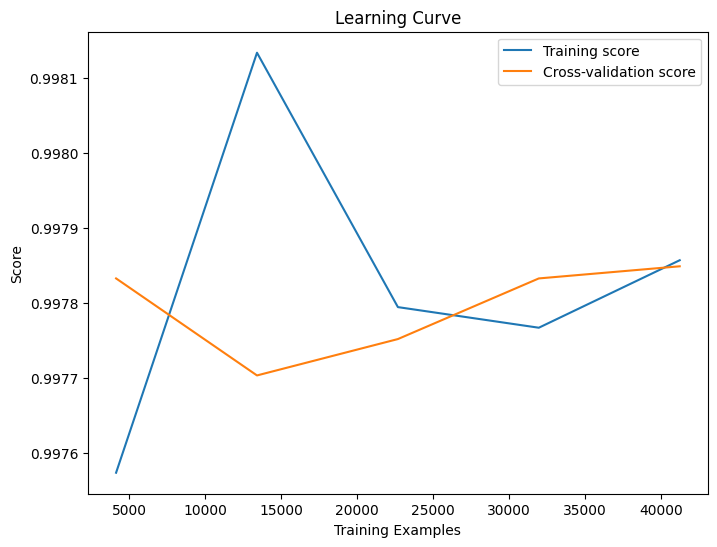

In [46]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_rf_classifier, X_train_imputed, y_train, cv=3, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()

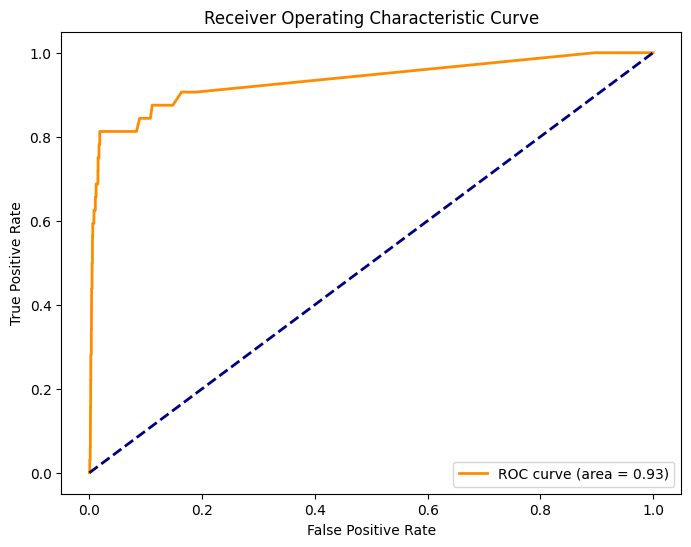

In [47]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, best_rf_classifier.predict_proba(X_test_imputed)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

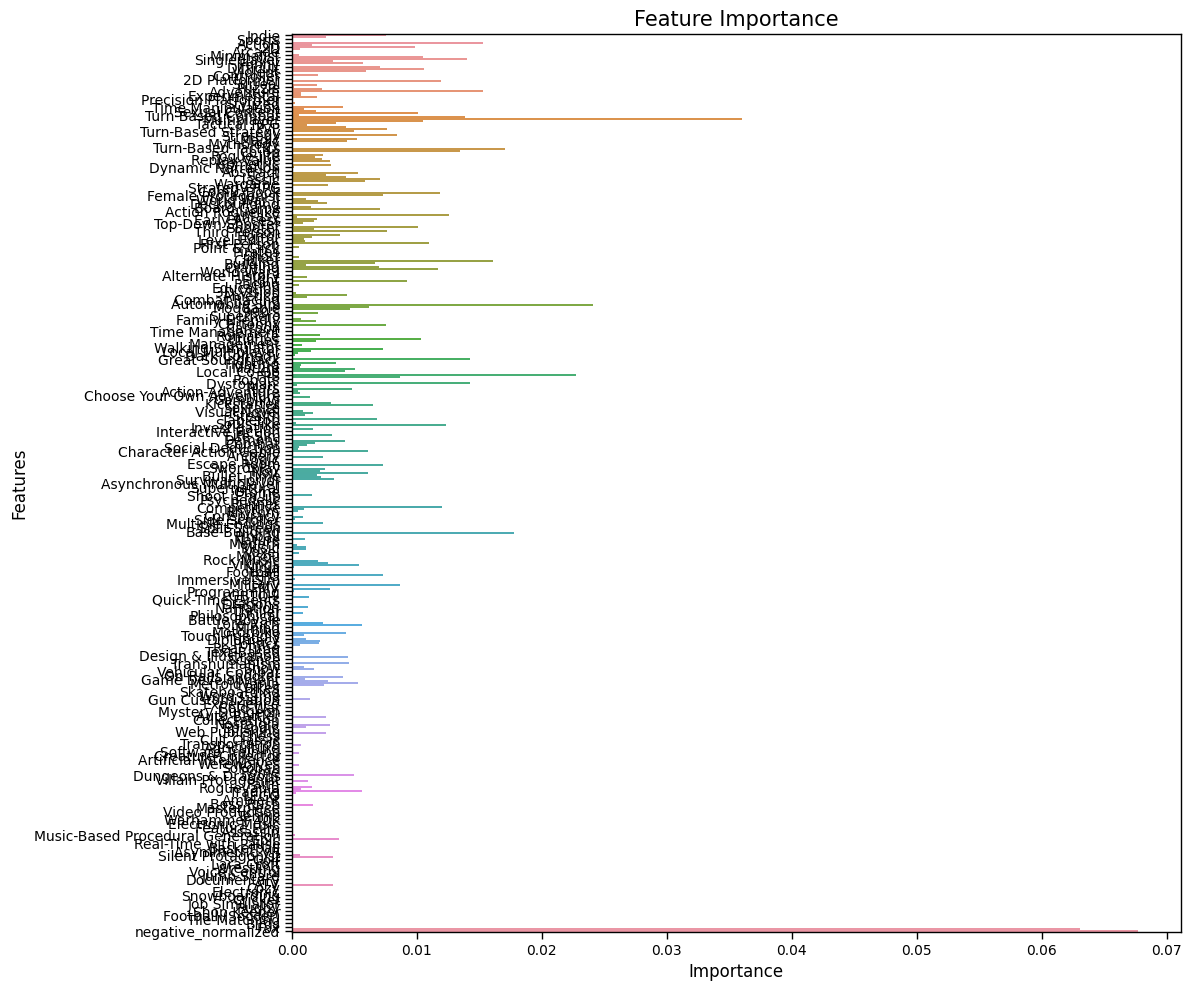

In [78]:
from matplotlib.ticker import MaxNLocator
feature_importance = best_rf_classifier.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 10))
ax = sns.barplot(x=feature_importance, y=feature_names, orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

ax.yaxis.set_major_locator(MaxNLocator(266))
plt.tight_layout()
plt.show()